# Inference trên Benchmark Dataset với Fine-tuned Model

Notebook này chạy inference trên benchmark dataset sử dụng model đã fine-tune.
Pipeline sử dụng fine-tuned model ở giai đoạn answering.


## 1. Cài đặt thư viện

In [1]:
%pip install -q transformers accelerate bitsandbytes qwen-vl-utils sentence-transformers rank-bm25 underthesea wikipedia pillow pandas tqdm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 41.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 110.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.4/978.4 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 55.5 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


## 2. Copy source code vào working directory


In [2]:
import shutil
from pathlib import Path

# Copy source code to Kaggle working directory
if Path('/kaggle/working').exists():
    # Option 1: Copy from input dataset (if you uploaded code as dataset)
    code_source = Path("/kaggle/input/code-src/code")  # Adjust path to your dataset
    code_dest = Path('/kaggle/working/code')
    
    if code_source.exists():
        if code_dest.exists():
            shutil.rmtree(code_dest)
        shutil.copytree(code_source, code_dest)
        print(f" Code copied to {code_dest}")
    else:
        print(f"  Code source not found at {code_source}")
        print("Creating src directory - you'll need to add your source files manually")
        # Create src directory structure manually
        code_dest = Path('/kaggle/working/code/src')
        code_dest.mkdir(parents=True, exist_ok=True)
        print(f"Created {code_dest}")
        print("Please add your source files (pipeline.py, vision.py, etc.) to this directory")
else:
    print("Not running in Kaggle environment")
    code_dest = Path('../src')


 Code copied to /kaggle/working/code


## 3. Import thư viện và setup paths


In [3]:
import json
import sys
from pathlib import Path
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torch
import os
import glob

# Add src to path
if Path('/kaggle/working').exists():
    sys.path.insert(0, '/kaggle/working/code/src')
else:
    sys.path.insert(0, '../src')
    
sys.path.insert(0, '/kaggle/working/code')


In [4]:
# Import pipeline
# Lưu ý: Nếu gặp lỗi "unexpected keyword argument 'kb_path'", 
# hãy chạy cell "Force Reload Modules" ở trên trước
try:
    from src.pipeline import RAGVQAPipeline
    print(" Pipeline imported successfully")
except ImportError as e:
    print(f" Error importing pipeline: {e}")
    print("Please make sure source files are in the correct location")
    raise

2026-01-03 15:31:53.281983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767454313.684824     106 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767454313.794068     106 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767454314.710927     106 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767454314.710956     106 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767454314.710958     106 computation_placer.cc:177] computation placer alr

 Pipeline imported successfully


## 3.1. Force Reload Modules (nếu đã chạy trước đó)

**Quan trọng**: Nếu bạn đã import pipeline trước đó và code đã được cập nhật, chạy cell này để reload:

In [5]:
# Force reload all src modules (chỉ cần chạy nếu gặp lỗi "unexpected keyword argument")
import sys
import importlib

# Danh sách modules cần reload
modules_to_reload = [
    'src.pipeline',
    'src.retrieval',
    'src.vision',
    'src.answering',
    'src.config',
    'src.prompts'
]

# Xóa cached modules
for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
        print(f" Cleared cache: {module_name}")

print("\n Modules cache cleared. Bây giờ chạy lại cell import ở dưới.")

 Cleared cache: src.pipeline
 Cleared cache: src.retrieval
 Cleared cache: src.vision
 Cleared cache: src.answering
 Cleared cache: src.config
 Cleared cache: src.prompts

 Modules cache cleared. Bây giờ chạy lại cell import ở dưới.


## 4. Cấu hình đường dẫn


In [6]:
# Paths cho Kaggle
if Path('/kaggle/working').exists():
    # Kaggle paths - ĐIỀU CHỈNH THEO DATASET CỦA BẠN
    KB_PATH = "/kaggle/input/knowledge-base/knowledge_base.json"
    IMAGES_DIR = "/kaggle/input/vqa-dataset/images_flat/images_flat"
    BENCHMARK_IMAGES_DIR = "/kaggle/input/dataset-benchmark/data/benchmark_images"
    BENCHMARK_JSON_PATH = "/kaggle/input/dataset-benchmark/data/benchmark_60.json"  # File chứa questions + ground truth
    FINETUNED_MODEL_PATH = "/kaggle/input/model-7b-tuned/models/qwen2vl-7b-vqa-grounded"
    VECTOR_DB_PATH = "/kaggle/input/vector-db"
    OUTPUT_DIR = "/kaggle/working/results"
else:
    # Local paths
    KB_PATH = "../../data/knowledge_base.json"
    IMAGES_DIR = "../../data/images_flat"
    BENCHMARK_IMAGES_DIR = "../../data/data-benchmark/benchmark_images"
    BENCHMARK_JSON_PATH = "../../data/data-benchmark/benchmark_60.json"  # File chứa questions + ground truth
    FINETUNED_MODEL_PATH = "../../models/qwen2vl-2b-vqa-grounded-merged"
    VECTOR_DB_PATH = "../../models/vector_db"
    OUTPUT_DIR = "../../results"

# Create output directory
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Load benchmark data từ JSON (chứa cả image, question, answer)
benchmark_data = []
benchmark_questions = {}
benchmark_ground_truth = {}

if Path(BENCHMARK_JSON_PATH).exists():
    with open(BENCHMARK_JSON_PATH, 'r', encoding='utf-8') as f:
        benchmark_data = json.load(f)
    
    # Build dictionaries
    for item in benchmark_data:
        img_name = item.get('image', '')
        benchmark_questions[img_name] = item.get('question', '')
        benchmark_ground_truth[img_name] = item.get('answer', '')
    
    print(f"✓ Loaded benchmark data: {len(benchmark_data)} samples")
    print(f"  - Questions: {len(benchmark_questions)}")
    print(f"  - Ground truth answers: {len(benchmark_ground_truth)}")
else:
    print(f"⚠ Benchmark JSON not found at {BENCHMARK_JSON_PATH}")

# Get list of benchmark images
benchmark_images = list(benchmark_questions.keys())
benchmark_images = sorted([img for img in benchmark_images if 'Zone.Identifier' not in img])

print(f"\nKnowledge Base: {KB_PATH}")
print(f"Benchmark Images Directory: {BENCHMARK_IMAGES_DIR}")
print(f"Benchmark JSON: {BENCHMARK_JSON_PATH}")
print(f"Fine-tuned Model Path: {FINETUNED_MODEL_PATH}")
print(f"Vector DB Path: {VECTOR_DB_PATH}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"\nFound {len(benchmark_images)} benchmark images")

# Verify paths exist
if Path(KB_PATH).exists():
    print(f" Knowledge base found")
else:
    print(f" Knowledge base NOT found at {KB_PATH}")

if Path(VECTOR_DB_PATH).exists():
    print(f" Vector DB found")
else:
    print(f" Vector DB NOT found - will create embeddings from scratch")

if Path(FINETUNED_MODEL_PATH).exists():
    print(f" Fine-tuned model found")
else:
    print(f" Fine-tuned model NOT found - will use base model")

✓ Loaded benchmark data: 60 samples
  - Questions: 60
  - Ground truth answers: 60

Knowledge Base: /kaggle/input/knowledge-base/knowledge_base.json
Benchmark Images Directory: /kaggle/input/dataset-benchmark/data/benchmark_images
Benchmark JSON: /kaggle/input/dataset-benchmark/data/benchmark_60.json
Fine-tuned Model Path: /kaggle/input/model-7b-tuned/models/qwen2vl-7b-vqa-grounded
Vector DB Path: /kaggle/input/vector-db
Output Directory: /kaggle/working/results

Found 60 benchmark images
 Knowledge base found
 Vector DB found
 Fine-tuned model found


## 5. Khởi tạo Pipeline với Fine-tuned Model


In [7]:
print("Initializing pipeline with fine-tuned model...")
print("This may take a few minutes to load the models...")

# Kiểm tra xem fine-tuned model có tồn tại không
if Path(FINETUNED_MODEL_PATH).exists():
    print(f" Using fine-tuned model from: {FINETUNED_MODEL_PATH}")
    answering_model = str(FINETUNED_MODEL_PATH)
else:
    print(f" Fine-tuned model not found at: {FINETUNED_MODEL_PATH}")
    print("  Falling back to base model: Qwen/Qwen2-VL-2B-Instruct")
    answering_model = "Qwen/Qwen2-VL-7B-Instruct"

# Initialize pipeline
try:
    pipeline = RAGVQAPipeline(
        vision_model_name="Qwen/Qwen2-VL-2B-Instruct",  # Base model for vision
        answering_model_name=answering_model,  # Fine-tuned or base model
        use_4bit=True,
        kb_path=KB_PATH,
        vector_db_path=VECTOR_DB_PATH
    )
    print("\n Pipeline ready!")
    if answering_model != "Qwen/Qwen2-VL-7B-Instruct":
        print(f"  - Vision: Qwen2-VL-2B (base)")
        print(f"  - Answering: Fine-tuned model")
    else:
        print(f"  - Vision: Qwen2-VL-2B (base)")
        print(f"  - Answering: Qwen2-VL-7B (base)")
except Exception as e:
    print(f" Error initializing pipeline: {e}")
    import traceback
    traceback.print_exc()
    raise

Initializing pipeline with fine-tuned model...
This may take a few minutes to load the models...
 Using fine-tuned model from: /kaggle/input/model-7b-tuned/models/qwen2vl-7b-vqa-grounded


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1422 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]


 Pipeline ready!
  - Vision: Qwen2-VL-2B (base)
  - Answering: Fine-tuned model


## 6. Load Benchmark Questions


In [8]:
# Hiển thị một số câu hỏi mẫu từ benchmark
print("=== Sample Benchmark Questions ===")
for i, img in enumerate(benchmark_images[:3]):
    print(f"\n{i+1}. Image: {img}")
    print(f"   Question: {benchmark_questions[img][:100]}...")
    print(f"   GT Answer: {benchmark_ground_truth[img][:100]}...")

# Default question (fallback nếu không có trong benchmark)
DEFAULT_QUESTION = "Đây là gì? Hãy mô tả chi tiết hình ảnh này và giải thích ý nghĩa văn hóa nếu có."

=== Sample Benchmark Questions ===

1. Image: 000000.jpg
   Question: Chiếc nón truyền thống mà các liền chị đang đội trong bức ảnh có tên gọi là gì và thường xuất hiện t...
   GT Answer: Chiếc nón các liền chị đang đội là Nón quai thao. Đây là một biểu tượng đặc trưng của văn hóa Quan h...

2. Image: 000001.jpg
   Question: Hình tượng rồng được trang trí trên mũi thuyền trong bức ảnh này mang những ý nghĩa biểu trưng sâu s...
   GT Answer: Biểu tượng của sức mạnh, quyền uy và thịnh vượng. Trong văn hóa và tín ngưỡng Việt Nam, rồng là một ...

3. Image: 000002.jpg
   Question: Trong quần thể di tích lịch sử và văn hóa nổi tiếng của Việt Nam, công trình kiến trúc được nhìn thấ...
   GT Answer: Khuê Văn Các. Đây là một trong những công trình kiến trúc tiêu biểu thuộc quần thể di tích Văn Miếu ...


## 7. Chạy inference trên Benchmark Dataset


In [9]:
results = []

print(f"\n{'='*80}")
print(f"Running Inference on {len(benchmark_images)} Benchmark Images")
print(f"{'='*80}\n")

for idx, image_name in enumerate(tqdm(benchmark_images, desc="Processing images")):
    try:
        # Load image
        image_path = Path(BENCHMARK_IMAGES_DIR) / image_name
        
        if not image_path.exists():
            print(f" Image not found: {image_path}")
            continue
        
        image = Image.open(image_path).convert('RGB')
        
        # Get question from benchmark (có sẵn từ cell trước)
        question = benchmark_questions.get(image_name, DEFAULT_QUESTION)
        
        # Print progress every 10 images
        if (idx + 1) % 10 == 0:
            print(f"\n[{idx+1}/{len(benchmark_images)}] Processing: {image_name}")
        
        # Get prediction
        result = pipeline.process(
            image=image,
            question=question,
            return_intermediate=True
        )
        
        # Separate retrieved docs by source
        retrieved_docs = result.get('retrieved_docs', [])
        kb_docs = [doc for doc in retrieved_docs if doc.get('source', '').startswith('kb_')]
        wiki_docs = [doc for doc in retrieved_docs if doc.get('source') == 'wikipedia']
        
        # Extract Wikipedia search keywords (if any)
        wiki_keywords = None
        if wiki_docs and len(wiki_docs) > 0:
            wiki_keywords = wiki_docs[0].get('keywords_used', None)
        
        # Store results
        results.append({
            'image': image_name,
            'question': question,
            'answer': result['answer'],
            'ground_truth': benchmark_ground_truth.get(image_name, ''),  # Lưu ground truth để so sánh
            'caption': result.get('caption', ''),
            'ocr': result.get('ocr', ''),
            'num_retrieved': len(retrieved_docs),
            'num_kb_docs': len(kb_docs),
            'num_wiki_docs': len(wiki_docs),
            'wiki_keywords': wiki_keywords,
            'context': result.get('context', '')[:500]  # Truncate for display
        })
        
    except Exception as e:
        print(f"\n✗ Error processing {image_name}: {e}")
        import traceback
        traceback.print_exc()
        results.append({
            'image': image_name,
            'question': benchmark_questions.get(image_name, ''),
            'answer': f'ERROR: {str(e)}',
            'ground_truth': benchmark_ground_truth.get(image_name, ''),
            'caption': '',
            'ocr': '',
            'num_retrieved': 0,
            'num_kb_docs': 0,
            'num_wiki_docs': 0,
            'wiki_keywords': None,
            'context': ''
        })

print(f"\n{'='*80}")
print(f" Completed inference on {len(results)} images")
print(f"  - Successful: {sum(1 for r in results if 'ERROR' not in r['answer'])}")
print(f"  - Errors: {sum(1 for r in results if 'ERROR' in r['answer'])}")
print(f"{'='*80}")


Running Inference on 60 Benchmark Images



Processing images:  15%|█▌        | 9/60 [01:55<11:57, 14.08s/it]


[10/60] Processing: 000009.jpg


Processing images:  32%|███▏      | 19/60 [04:03<09:03, 13.25s/it]


[20/60] Processing: 000019.jpg


Processing images:  48%|████▊     | 29/60 [06:19<07:05, 13.72s/it]


[30/60] Processing: 000029.jpg


Processing images:  65%|██████▌   | 39/60 [08:22<04:20, 12.41s/it]


[40/60] Processing: 000039.jpg


Processing images:  82%|████████▏ | 49/60 [10:44<02:31, 13.74s/it]


[50/60] Processing: 000049.jpg


Processing images:  98%|█████████▊| 59/60 [12:55<00:12, 12.59s/it]


[60/60] Processing: 000059.jpg


Processing images: 100%|██████████| 60/60 [13:04<00:00, 13.08s/it]


 Completed inference on 60 images
  - Successful: 60
  - Errors: 0


## 8. Lưu kết quả


In [10]:
# Save to JSON
output_json = f"{OUTPUT_DIR}/benchmark_inference_results_finetuned.json"
with open(output_json, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)
print(f" Results saved to {output_json}")

# Save to CSV for easy viewing
df = pd.DataFrame(results)
output_csv = f"{OUTPUT_DIR}/benchmark_inference_results_finetuned.csv"
df.to_csv(output_csv, index=False, encoding='utf-8-sig')
print(f" Results saved to {output_csv}")

# Display summary
print("\n=== Inference Summary ===")
print(f"Total images processed: {len(results)}")
if len(results) > 0:
    print(f"Average retrieved docs: {df['num_retrieved'].mean():.2f}")
    print(f"Images with caption: {(df['caption'] != '').sum()}")
    print(f"Images with OCR: {(df['ocr'] != '').sum()}")
    print(f"Images with KB docs: {(df['num_kb_docs'] > 0).sum()}")
    print(f"Images with Wikipedia docs: {(df['num_wiki_docs'] > 0).sum()}")


 Results saved to /kaggle/working/results/benchmark_inference_results_finetuned.json
 Results saved to /kaggle/working/results/benchmark_inference_results_finetuned.csv

=== Inference Summary ===
Total images processed: 60
Average retrieved docs: 3.00
Images with caption: 60
Images with OCR: 1
Images with KB docs: 60
Images with Wikipedia docs: 0


## 9. Hiển thị một vài kết quả mẫu


In [11]:
# Display first 5 results
num_samples = min(5, len(results))
for i in range(num_samples):
    result = results[i]
    print(f"\n{'='*80}")
    print(f"Sample {i+1}: {result['image']}")
    print(f"{'='*80}")
    print(f"Question: {result['question']}")
    print(f"\nAnswer:")
    print(result['answer'])
    if result['caption']:
        print(f"\nCaption: {result['caption'][:300]}..." if len(result['caption']) > 300 else f"\nCaption: {result['caption']}")
    if result['ocr']:
        print(f"\nOCR: {result['ocr'][:200]}..." if len(result['ocr']) > 200 else f"\nOCR: {result['ocr']}")
    print(f"\nRetrieved docs: {result['num_retrieved']} (KB: {result['num_kb_docs']}, Wiki: {result['num_wiki_docs']})")



Sample 1: 000000.jpg
Question: Chiếc nón truyền thống mà các liền chị đang đội trong bức ảnh có tên gọi là gì và thường xuất hiện trong loại hình nghệ thuật dân gian nào của Việt Nam, đặc biệt là ở vùng châu thổ sông Hồng?

Answer:
Nón lá

Đây là nón lá, một loại mũ được làm từ lá chuối hoặc mít, rất phổ biến ở miền Bắc Việt Nam. Nó thường xuất hiện nhiều trong các tác phẩm nghệ thuật dân tộc, đặc biệt trong các lễ hội, biểu diễn nghệ thuật truyền thống như hát chầu văn, múa rối nước... Nón lá cũng là một phần không thể thiếu trong đời sống hàng ngày của người dân vùng nông thôn.

Caption: Hình ảnh này mô tả một nhóm người mặc trang phục truyền thống Việt Nam đang đứng trước cổng một ngôi đền. Họ đang cầm những chiếc khăn tròn màu đỏ, vàng, trắng và đỏ, mang màu sắc và hình thức khác nhau. Một người đang cầm một chiếc khăn màu đỏ có một dây màu vàng. Họ đang đứng trước một cổng có một...

Retrieved docs: 3 (KB: 3, Wiki: 0)

Sample 2: 000001.jpg
Question: Hình tượng rồng được trang trí

---

# PHẦN 2: SO SÁNH HIỆU SUẤT FINE-TUNED VS BASE MODEL

So sánh hiệu suất giữa:
1. **Fine-tuned Qwen2-VL-7B** (model đã train)
2. **Base Qwen2-VL-7B-Instruct** (model gốc)

Các metrics đánh giá:
- **BERTScore**: Đánh giá semantic similarity
- **ROUGE-L**: Đánh giá overlap n-gram (longest common subsequence)
- **Faithfulness**: Đánh giá mức độ trung thực với context

## 10. Cài đặt thư viện đánh giá

In [12]:
# Packages đã được cài đặt ở cell đầu tiên
# Chỉ cần import
import nltk
nltk.download('punkt', quiet=True)
print(" NLTK punkt downloaded")

 NLTK punkt downloaded


## 11. Lưu kết quả Fine-tuned model và giải phóng bộ nhớ

In [13]:
# Lưu kết quả fine-tuned model để dùng cho so sánh
finetuned_results = results.copy()
print(f"✓ Đã lưu {len(finetuned_results)} kết quả từ Fine-tuned model")

# Giải phóng bộ nhớ GPU
import gc
import torch

# Xóa pipeline cũ
if 'pipeline' in dir():
    del pipeline
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f" Đã giải phóng bộ nhớ GPU")
    print(f"  VRAM available: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

✓ Đã lưu 60 kết quả từ Fine-tuned model
 Đã giải phóng bộ nhớ GPU
  VRAM available: 79.4 GB


## 12. Khởi tạo Pipeline với Base Model (Qwen2-VL-7B-Instruct)

In [14]:
print("Initializing pipeline with BASE model (Qwen2-VL-2B-Instruct)...")
print("This will be used for comparison with fine-tuned model")

# Reload modules để đảm bảo dùng code mới nhất
import sys
modules_to_reload = ['src.pipeline', 'src.retrieval', 'src.vision', 'src.answering', 'src.config', 'src.prompts']
for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

from src.pipeline import RAGVQAPipeline

# Define base model ID for later use
BASE_MODEL_ID = "Qwen/Qwen2-VL-7B-Instruct"

# Initialize pipeline với BASE model (không phải fine-tuned)
try:
    pipeline_base = RAGVQAPipeline(
        vision_model_name="Qwen/Qwen2-VL-2B-Instruct",  # Base model for vision
        answering_model_name=BASE_MODEL_ID,  # Base model for answering (KHÔNG FINE-TUNED)
        use_4bit=True,
        kb_path=KB_PATH,
        vector_db_path=VECTOR_DB_PATH
    )
    print(" Pipeline with BASE model ready!")
except Exception as e:
    print(f" Error initializing BASE pipeline: {e}")
    import traceback
    traceback.print_exc()
    raise

Initializing pipeline with BASE model (Qwen2-VL-2B-Instruct)...
This will be used for comparison with fine-tuned model


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1422 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

 Pipeline with BASE model ready!


## 13. Chạy inference với Base Model trên cùng benchmark

In [15]:
base_results = []

print(f"\n{'='*80}")
print(f"Running Inference with BASE MODEL on {len(benchmark_images)} Benchmark Images")
print(f"{'='*80}\n")

for idx, image_name in enumerate(tqdm(benchmark_images, desc="Processing with BASE model")):
    try:
        # Load image
        image_path = Path(BENCHMARK_IMAGES_DIR) / image_name
        
        if not image_path.exists():
            print(f"⚠ Image not found: {image_path}")
            continue
        
        image = Image.open(image_path).convert('RGB')
        
        # Get question (dùng cùng câu hỏi như fine-tuned)
        question = benchmark_questions.get(image_name, DEFAULT_QUESTION)
        
        # Print progress every 10 images
        if (idx + 1) % 10 == 0:
            print(f"\n[{idx+1}/{len(benchmark_images)}] Processing: {image_name}")
        
        # Get prediction from BASE model
        result = pipeline_base.process(
            image=image,
            question=question,
            return_intermediate=True
        )
        
        # Separate retrieved docs
        retrieved_docs = result.get('retrieved_docs', [])
        kb_docs = [doc for doc in retrieved_docs if doc.get('source', '').startswith('kb_')]
        wiki_docs = [doc for doc in retrieved_docs if doc.get('source') == 'wikipedia']
        
        wiki_keywords = None
        if wiki_docs and len(wiki_docs) > 0:
            wiki_keywords = wiki_docs[0].get('keywords_used', None)
        
        # Store results
        base_results.append({
            'image': image_name,
            'question': question,
            'answer': result['answer'],
            'ground_truth': benchmark_ground_truth.get(image_name, ''),
            'caption': result.get('caption', ''),
            'ocr': result.get('ocr', ''),
            'num_retrieved': len(retrieved_docs),
            'num_kb_docs': len(kb_docs),
            'num_wiki_docs': len(wiki_docs),
            'wiki_keywords': wiki_keywords,
            'context': result.get('context', '')[:500]
        })
        
    except Exception as e:
        print(f"\n✗ Error processing {image_name}: {e}")
        import traceback
        traceback.print_exc()
        base_results.append({
            'image': image_name,
            'question': benchmark_questions.get(image_name, ''),
            'answer': f'ERROR: {str(e)}',
            'ground_truth': benchmark_ground_truth.get(image_name, ''),
            'caption': '',
            'ocr': '',
            'num_retrieved': 0,
            'num_kb_docs': 0,
            'num_wiki_docs': 0,
            'wiki_keywords': None,
            'context': ''
        })

print(f"\n{'='*80}")
print(f" Completed BASE model inference on {len(base_results)} images")
print(f"  - Successful: {sum(1 for r in base_results if 'ERROR' not in r['answer'])}")
print(f"  - Errors: {sum(1 for r in base_results if 'ERROR' in r['answer'])}")
print(f"{'='*80}")


Running Inference with BASE MODEL on 60 Benchmark Images



Processing with BASE model:  15%|█▌        | 9/60 [01:59<11:49, 13.91s/it]


[10/60] Processing: 000009.jpg


Processing with BASE model:  32%|███▏      | 19/60 [04:28<10:39, 15.60s/it]


[20/60] Processing: 000019.jpg


Processing with BASE model:  48%|████▊     | 29/60 [06:53<07:48, 15.11s/it]


[30/60] Processing: 000029.jpg


Processing with BASE model:  65%|██████▌   | 39/60 [09:09<04:39, 13.32s/it]


[40/60] Processing: 000039.jpg


Processing with BASE model:  82%|████████▏ | 49/60 [11:35<02:47, 15.22s/it]


[50/60] Processing: 000049.jpg


Processing with BASE model:  98%|█████████▊| 59/60 [13:58<00:14, 14.22s/it]


[60/60] Processing: 000059.jpg


Processing with BASE model: 100%|██████████| 60/60 [14:10<00:00, 14.18s/it]


 Completed BASE model inference on 60 images
  - Successful: 60
  - Errors: 0


## 14. Lưu kết quả Base Model

In [16]:
# Save base model results to JSON
output_json_base = f"{OUTPUT_DIR}/benchmark_inference_results_base.json"
with open(output_json_base, 'w', encoding='utf-8') as f:
    json.dump(base_results, f, ensure_ascii=False, indent=2)
print(f" Base model results saved to {output_json_base}")

# Save to CSV
df_base = pd.DataFrame(base_results)
output_csv_base = f"{OUTPUT_DIR}/benchmark_inference_results_base.csv"
df_base.to_csv(output_csv_base, index=False, encoding='utf-8-sig')
print(f" Base model results saved to {output_csv_base}")

 Base model results saved to /kaggle/working/results/benchmark_inference_results_base.json
 Base model results saved to /kaggle/working/results/benchmark_inference_results_base.csv


---

# PHẦN 3: SO SÁNH VỚI QWEN2-VL-2B ZERO-SHOT

Thêm 2 baseline nữa để so sánh:
1. **Qwen2-VL-2B Zero-shot**: Model Qwen2-VL-2B KHÔNG sử dụng RAG (trả lời trực tiếp từ ảnh)

Tổng cộng 3 models để so sánh:
- RAG Pipeline + Fine-tuned Qwen2-VL-2B
- RAG Pipeline + Base Qwen2-VL-2B  
- Qwen2-VL-2B Zero-shot (không RAG)


## 14.1. Giải phóng bộ nhớ cho Base Pipeline

In [17]:
# Giải phóng bộ nhớ từ base pipeline
import gc
import torch

if 'pipeline_base' in dir():
    del pipeline_base
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print(" Đã giải phóng bộ nhớ GPU từ Base Pipeline")

 Đã giải phóng bộ nhớ GPU từ Base Pipeline


## 14.2. Qwen2-VL-2B Zero-shot (Không RAG)

Chạy inference trực tiếp với Qwen2-VL-2B **KHÔNG** sử dụng RAG pipeline.
Model chỉ dựa vào visual understanding để trả lời câu hỏi.

In [ ]:
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
from qwen_vl_utils import process_vision_info

# Load Qwen2-VL-2B for zero-shot inference
print("Loading Qwen2-VL-2B for Zero-shot inference...")

QWEN_ZEROSHOT_MODEL = "Qwen/Qwen2-VL-2B-Instruct"

# Quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

# Load model
qwen_zeroshot_model = Qwen2VLForConditionalGeneration.from_pretrained(
    QWEN_ZEROSHOT_MODEL,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16
)
qwen_zeroshot_processor = AutoProcessor.from_pretrained(QWEN_ZEROSHOT_MODEL)

print(f" Qwen2-VL-2B Zero-shot model loaded!")


def qwen_zeroshot_inference(image, question):
    """
    Run zero-shot inference with Qwen2-VL-2B (no RAG)
    """
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": f"Hãy trả lời câu hỏi sau bằng tiếng Việt dựa trên hình ảnh:\n\nCâu hỏi: {question}"}
            ]
        }
    ]
    
    # Prepare input
    text = qwen_zeroshot_processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = qwen_zeroshot_processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    ).to(qwen_zeroshot_model.device)
    
    # Generate
    with torch.no_grad():
        generated_ids = qwen_zeroshot_model.generate(
            **inputs,
            max_new_tokens=512,
            do_sample=False
        )
    
    # Decode
    generated_ids_trimmed = [
        out_ids[len(in_ids):] 
        for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = qwen_zeroshot_processor.batch_decode(
        generated_ids_trimmed, 
        skip_special_tokens=True, 
        clean_up_tokenization_spaces=False
    )[0]
    
    return output_text

print(" Zero-shot inference function ready!")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading Qwen2-VL-2B for Zero-shot inference...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Qwen2-VL-2B Zero-shot model loaded!
 Zero-shot inference function ready!


## 14.3. Chạy inference Qwen2-VL-2B Zero-shot trên benchmark

In [19]:
zeroshot_results = []

print(f"\n{'='*80}")
print(f"Running ZERO-SHOT Inference with Qwen2-VL-2B on {len(benchmark_images)} Images")
print(f"{'='*80}\n")

for idx, image_name in enumerate(tqdm(benchmark_images, desc="Zero-shot inference")):
    try:
        # Load image
        image_path = Path(BENCHMARK_IMAGES_DIR) / image_name
        
        if not image_path.exists():
            continue
        
        image = Image.open(image_path).convert('RGB')
        
        # Get question
        question = benchmark_questions.get(image_name, DEFAULT_QUESTION)
        
        # Print progress
        if (idx + 1) % 10 == 0:
            print(f"\n[{idx+1}/{len(benchmark_images)}] Processing: {image_name}")
        
        # Get zero-shot prediction
        answer = qwen_zeroshot_inference(image, question)
        
        zeroshot_results.append({
            'image': image_name,
            'question': question,
            'answer': answer,
            'ground_truth': benchmark_ground_truth.get(image_name, ''),
            'context': ''  # No RAG context
        })
        
    except Exception as e:
        print(f"\n✗ Error processing {image_name}: {e}")
        zeroshot_results.append({
            'image': image_name,
            'question': benchmark_questions.get(image_name, ''),
            'answer': f'ERROR: {str(e)}',
            'ground_truth': benchmark_ground_truth.get(image_name, ''),
            'context': ''
        })

print(f"\n{'='*80}")
print(f" Completed Zero-shot inference on {len(zeroshot_results)} images")
print(f"  - Successful: {sum(1 for r in zeroshot_results if 'ERROR' not in r['answer'])}")
print(f"  - Errors: {sum(1 for r in zeroshot_results if 'ERROR' in r['answer'])}")
print(f"{'='*80}")

# Save results
output_json_zs = f"{OUTPUT_DIR}/benchmark_inference_results_zeroshot.json"
with open(output_json_zs, 'w', encoding='utf-8') as f:
    json.dump(zeroshot_results, f, ensure_ascii=False, indent=2)
print(f" Zero-shot results saved to {output_json_zs}")


Running ZERO-SHOT Inference with Qwen2-VL-2B on 60 Images



Zero-shot inference:  15%|█▌        | 9/60 [00:33<02:14,  2.63s/it]


[10/60] Processing: 000009.jpg


Zero-shot inference:  32%|███▏      | 19/60 [01:00<02:07,  3.10s/it]


[20/60] Processing: 000019.jpg


Zero-shot inference:  48%|████▊     | 29/60 [01:29<00:59,  1.93s/it]


[30/60] Processing: 000029.jpg


Zero-shot inference:  65%|██████▌   | 39/60 [01:53<00:49,  2.36s/it]


[40/60] Processing: 000039.jpg


Zero-shot inference:  82%|████████▏ | 49/60 [02:12<00:20,  1.89s/it]


[50/60] Processing: 000049.jpg


Zero-shot inference:  98%|█████████▊| 59/60 [03:07<00:06,  6.76s/it]


[60/60] Processing: 000059.jpg


Zero-shot inference: 100%|██████████| 60/60 [03:08<00:00,  3.15s/it]


 Completed Zero-shot inference on 60 images
  - Successful: 60
  - Errors: 0
 Zero-shot results saved to /kaggle/working/results/benchmark_inference_results_zeroshot.json


## 14.4. Giải phóng bộ nhớ Qwen Zero-shot

In [20]:
# Giải phóng Qwen Zero-shot model
del qwen_zeroshot_model
del qwen_zeroshot_processor
gc.collect()
torch.cuda.empty_cache()
print(" Đã giải phóng bộ nhớ Qwen Zero-shot")

 Đã giải phóng bộ nhớ Qwen Zero-shot


## 15. Định nghĩa các hàm tính metrics

In [26]:
pip install bert_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: Could not find a version that satisfies the requirement rough_score (from versions: none)
ERROR: No matching distribution found for rough_score
Note: you may need to restart the kernel to use updated packages.


In [28]:
pip install rouge_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=8dc91322573104bfe2ee3e649367e00f74a043e93450f791b8bc2b0cb1acbd40
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score
Note: you may need to restart the kernel to use updated packages.


In [29]:
import numpy as np
from bert_score import score as bert_score
from rouge_score import rouge_scorer
import re

def compute_bertscore(predictions, references, lang='vi'):
    """
    Compute BERTScore for Vietnamese text
    
    Args:
        predictions: List of predicted answers
        references: List of reference answers
        lang: Language code ('vi' for Vietnamese)
    
    Returns:
        Dictionary with P, R, F1 scores
    """
    # Check for empty lists
    if not predictions or not references:
        print(f"WARNING: Empty list detected - predictions: {len(predictions) if predictions else 0}, references: {len(references) if references else 0}")
        return {
            'precision': 0.0,
            'recall': 0.0,
            'f1': 0.0,
            'precision_std': 0.0,
            'recall_std': 0.0,
            'f1_std': 0.0,
            'individual_f1': []
        }
    
    # BERTScore với multilingual model
    P, R, F1 = bert_score(
        predictions, 
        references, 
        lang=lang,
        verbose=True
    )
    
    return {
        'precision': P.mean().item(),
        'recall': R.mean().item(),
        'f1': F1.mean().item(),
        'precision_std': P.std().item(),
        'recall_std': R.std().item(),
        'f1_std': F1.std().item(),
        'individual_f1': F1.tolist()
    }

def compute_rouge_l(predictions, references):
    """
    Compute ROUGE-L score
    
    Args:
        predictions: List of predicted answers
        references: List of reference answers
    
    Returns:
        Dictionary with ROUGE-L scores
    """
    # Check for empty lists
    if not predictions or not references:
        print(f"WARNING: Empty list detected - predictions: {len(predictions) if predictions else 0}, references: {len(references) if references else 0}")
        return {
            'precision': 0.0,
            'recall': 0.0,
            'f1': 0.0,
            'precision_std': 0.0,
            'recall_std': 0.0,
            'f1_std': 0.0,
            'individual_f1': []
        }
    
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False)
    
    scores = []
    for pred, ref in zip(predictions, references):
        # Compute score for each pair
        score = scorer.score(ref, pred)
        scores.append({
            'precision': score['rougeL'].precision,
            'recall': score['rougeL'].recall,
            'fmeasure': score['rougeL'].fmeasure
        })
    
    # Aggregate scores
    avg_precision = np.mean([s['precision'] for s in scores])
    avg_recall = np.mean([s['recall'] for s in scores])
    avg_fmeasure = np.mean([s['fmeasure'] for s in scores])
    
    return {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1': avg_fmeasure,
        'precision_std': np.std([s['precision'] for s in scores]),
        'recall_std': np.std([s['recall'] for s in scores]),
        'f1_std': np.std([s['fmeasure'] for s in scores]),
        'individual_f1': [s['fmeasure'] for s in scores]
    }

def compute_faithfulness(predictions, contexts):
    """
    Compute Faithfulness score - đo mức độ answer dựa trên context
    
    Faithfulness = số lượng claims trong answer có thể verify từ context / tổng số claims
    
    Simplified version: Đo overlap của n-grams giữa answer và context
    
    Args:
        predictions: List of predicted answers
        contexts: List of contexts used for generation
    
    Returns:
        Dictionary with faithfulness scores
    """
    # Check for empty lists
    if not predictions or not contexts:
        print(f"WARNING: Empty list detected - predictions: {len(predictions) if predictions else 0}, contexts: {len(contexts) if contexts else 0}")
        return {
            'mean': 0.0,
            'std': 0.0,
            'individual': []
        }
    
    def tokenize(text):
        """Simple tokenization"""
        if not text:
            return []
        # Remove punctuation and lowercase
        text = re.sub(r'[^\w\s]', ' ', text.lower())
        return text.split()
    
    def get_ngrams(tokens, n):
        """Get n-grams from tokens"""
        if len(tokens) < n:
            return set()
        return set([' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)])
    
    def compute_overlap(answer, context, n=2):
        """Compute n-gram overlap ratio"""
        answer_tokens = tokenize(answer)
        context_tokens = tokenize(context)
        
        if not answer_tokens:
            return 0.0
        
        answer_ngrams = get_ngrams(answer_tokens, n)
        context_ngrams = get_ngrams(context_tokens, n)
        
        if not answer_ngrams:
            return 0.0
        
        overlap = answer_ngrams.intersection(context_ngrams)
        return len(overlap) / len(answer_ngrams)
    
    scores = []
    for pred, ctx in zip(predictions, contexts):
        if not ctx or ctx == 'None' or 'không tìm thấy' in ctx.lower():
            # Nếu không có context, không thể đánh giá faithfulness
            scores.append(0.0)
        else:
            # Compute overlap với bigrams và trigrams
            bigram_overlap = compute_overlap(pred, ctx, n=2)
            trigram_overlap = compute_overlap(pred, ctx, n=3)
            # Average
            scores.append((bigram_overlap + trigram_overlap) / 2)
    
    return {
        'mean': np.mean(scores),
        'std': np.std(scores),
        'individual': scores
    }

print(" Đã định nghĩa các hàm tính metrics:")

 Đã định nghĩa các hàm tính metrics:


## 16. Chuẩn bị dữ liệu để so sánh

In [ ]:
# Ground truth đã được load từ đầu (benchmark_ground_truth)
print(f" Ground truth available: {len(benchmark_ground_truth)} samples")

# Match by image name - tạo dict cho 3 models
finetuned_dict = {r['image']: r for r in finetuned_results}
base_dict = {r['image']: r for r in base_results}
zeroshot_dict = {r['image']: r for r in zeroshot_results}

# Debug: Print number of results from each model
print(f"\nDebug - Number of results per model:")
print(f"  - Fine-tuned: {len(finetuned_dict)}")
print(f"  - Base: {len(base_dict)}")
print(f"  - Zero-shot: {len(zeroshot_dict)}")
print(f"  - Ground truth: {len(benchmark_ground_truth)}")

# Check how many valid (non-ERROR) results each model has
def count_valid_results(model_dict):
    return sum(1 for r in model_dict.values() if 'ERROR' not in r.get('answer', 'ERROR'))

ft_valid = count_valid_results(finetuned_dict)
base_valid = count_valid_results(base_dict)
zs_valid = count_valid_results(zeroshot_dict)

print(f"\nDebug - Valid (non-ERROR) results per model:")
print(f"  - Fine-tuned: {ft_valid}/{len(finetuned_dict)}")
print(f"  - Base: {base_valid}/{len(base_dict)}")
print(f"  - Zero-shot: {zs_valid}/{len(zeroshot_dict)}")

# Get common images (3 models + ground truth)
common_images = (set(finetuned_dict.keys()) & set(base_dict.keys()) & 
                 set(zeroshot_dict.keys()) & set(benchmark_ground_truth.keys()))

print(f"\nSố lượng images chung: {len(common_images)}")

# Filter out ERROR results
valid_images = []
skipped_count = {'finetuned': 0, 'base': 0, 'zeroshot': 0}

for img in common_images:
    has_error = False
    
    if 'ERROR' in finetuned_dict[img]['answer']:
        has_error = True
        skipped_count['finetuned'] += 1
    if 'ERROR' in base_dict[img]['answer']:
        has_error = True
        skipped_count['base'] += 1
    if 'ERROR' in zeroshot_dict[img]['answer']:
        has_error = True
        skipped_count['zeroshot'] += 1
    
    if not has_error:
        valid_images.append(img)

valid_images = sorted(valid_images)
print(f"Số lượng images valid (không có lỗi): {len(valid_images)}")

if any(skipped_count.values()):
    print(f"\nSkipped images by model:")
    for model, count in skipped_count.items():
        if count > 0:
            print(f"  - {model}: {count} images with ERROR")

# Check if valid_images is empty
if len(valid_images) == 0:
    print("\n" + "="*80)
    print("ERROR: No valid images found for evaluation!")
    print("="*80)
    raise ValueError("No valid images found for evaluation.")

# Prepare lists for comparison (3 models only)
finetuned_answers = [finetuned_dict[img]['answer'] for img in valid_images]
base_answers = [base_dict[img]['answer'] for img in valid_images]
zeroshot_answers = [zeroshot_dict[img]['answer'] for img in valid_images]
ground_truth_answers = [benchmark_ground_truth[img] for img in valid_images]

# Contexts
finetuned_contexts = [finetuned_dict[img].get('context', '') for img in valid_images]
base_contexts = [base_dict[img].get('context', '') for img in valid_images]
zeroshot_contexts = ['' for _ in valid_images]

questions = [benchmark_questions[img] for img in valid_images]

print(f"\n{'='*60}")
print(f"Đã chuẩn bị dữ liệu cho 3 MODELS:")
print(f"{'='*60}")
print(f"  - RAG + Fine-tuned answers: {len(finetuned_answers)}")
print(f"  - RAG + Base answers: {len(base_answers)}")
print(f"  - Qwen2-VL-7B Zero-shot answers: {len(zeroshot_answers)}")
print(f"  - Ground truth answers: {len(ground_truth_answers)}")

✓ Ground truth available: 60 samples

Debug - Number of results per model:
  - Fine-tuned: 60
  - Base: 60
  - Zero-shot: 60
  - Ground truth: 60

Debug - Valid (non-ERROR) results per model:
  - Fine-tuned: 60/60
  - Base: 60/60
  - Zero-shot: 60/60

Số lượng images chung: 60
Số lượng images valid (không có lỗi): 60

Đã chuẩn bị dữ liệu cho 3 MODELS:
  - RAG + Fine-tuned answers: 60
  - RAG + Base answers: 60
  - Qwen2-VL-7B Zero-shot answers: 60
  - Ground truth answers: 60


## 17. Tính BERTScore

So sánh answers của **3 MODELS** với **Ground Truth**:
1. RAG Pipeline + Fine-tuned Qwen2-VL-2B
2. RAG Pipeline + Base Qwen2-VL-2B
3. Qwen2-VL-2B Zero-shot (không RAG)

In [31]:
print("="*80)
print("COMPUTING BERTScore (so với Ground Truth) - 3 MODELS")
print("="*80)

# 1. BERTScore: RAG + Fine-tuned vs Ground Truth
print("\n1. BERTScore: RAG + Fine-tuned vs Ground Truth")
bertscore_ft_gt = compute_bertscore(finetuned_answers, ground_truth_answers, lang='vi')
print(f"   F1: {bertscore_ft_gt['f1']:.4f} ± {bertscore_ft_gt['f1_std']:.4f}")

# 2. BERTScore: RAG + Base vs Ground Truth
print("\n2. BERTScore: RAG + Base vs Ground Truth")
bertscore_base_gt = compute_bertscore(base_answers, ground_truth_answers, lang='vi')
print(f"   F1: {bertscore_base_gt['f1']:.4f} ± {bertscore_base_gt['f1_std']:.4f}")

# 3. BERTScore: Zero-shot vs Ground Truth
print("\n3. BERTScore: Qwen2-VL-7B Zero-shot vs Ground Truth")
bertscore_zs_gt = compute_bertscore(zeroshot_answers, ground_truth_answers, lang='vi')
print(f"   F1: {bertscore_zs_gt['f1']:.4f} ± {bertscore_zs_gt['f1_std']:.4f}")

# Summary ranking
print("\n" + "="*80)
print("BERTScore F1 RANKING:")
print("="*80)
bert_rankings = [
    ('RAG + Fine-tuned', bertscore_ft_gt['f1']),
    ('RAG + Base', bertscore_base_gt['f1']),
    ('Qwen2-VL-7B Zero-shot', bertscore_zs_gt['f1']),
]

bert_rankings.sort(key=lambda x: x[1], reverse=True)
for i, (name, score) in enumerate(bert_rankings, 1):
    print(f"  {i}. {name}: {score:.4f}")

COMPUTING BERTScore (so với Ground Truth) - 3 MODELS

1. BERTScore: RAG + Fine-tuned vs Ground Truth


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/2 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.32 seconds, 188.62 sentences/sec
   F1: 0.7415 ± 0.0301

2. BERTScore: RAG + Base vs Ground Truth
calculating scores...
computing bert embedding.


  0%|          | 0/2 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.28 seconds, 216.88 sentences/sec
   F1: 0.7179 ± 0.0301

3. BERTScore: Qwen2-VL-7B Zero-shot vs Ground Truth
calculating scores...
computing bert embedding.


  0%|          | 0/2 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.28 seconds, 214.96 sentences/sec
   F1: 0.7125 ± 0.0500

BERTScore F1 RANKING:
  1. RAG + Fine-tuned: 0.7415
  2. RAG + Base: 0.7179
  3. Qwen2-VL-7B Zero-shot: 0.7125


## 18. Tính ROUGE-L Score

So sánh answers của **3 MODELS** với **Ground Truth** sử dụng ROUGE-L.

In [32]:
print("="*80)
print("COMPUTING ROUGE-L Score (so với Ground Truth) - 3 MODELS")
print("="*80)

# ROUGE-L: Fine-tuned vs Ground Truth
print("\n1. ROUGE-L: RAG + Fine-tuned vs Ground Truth")
rouge_ft_gt = compute_rouge_l(finetuned_answers, ground_truth_answers)

print(f"\n   Fine-tuned vs. Ground Truth:")
print(f"   Precision: {rouge_ft_gt['precision']:.4f} ± {rouge_ft_gt['precision_std']:.4f}")
print(f"   Recall:    {rouge_ft_gt['recall']:.4f} ± {rouge_ft_gt['recall_std']:.4f}")
print(f"   F1:        {rouge_ft_gt['f1']:.4f} ± {rouge_ft_gt['f1_std']:.4f}")

# ROUGE-L: Base vs Ground Truth
print("\n2. ROUGE-L: RAG + Base vs Ground Truth")
rouge_base_gt = compute_rouge_l(base_answers, ground_truth_answers)

print(f"\n   Base vs. Ground Truth:")
print(f"   Precision: {rouge_base_gt['precision']:.4f} ± {rouge_base_gt['precision_std']:.4f}")
print(f"   Recall:    {rouge_base_gt['recall']:.4f} ± {rouge_base_gt['recall_std']:.4f}")
print(f"   F1:        {rouge_base_gt['f1']:.4f} ± {rouge_base_gt['f1_std']:.4f}")

# ROUGE-L: Zero-shot vs Ground Truth
print("\n3. ROUGE-L: Qwen2-VL-2B Zero-shot vs Ground Truth")
rouge_zs_gt = compute_rouge_l(zeroshot_answers, ground_truth_answers)

print(f"\n   Zero-shot vs. Ground Truth:")
print(f"   Precision: {rouge_zs_gt['precision']:.4f} ± {rouge_zs_gt['precision_std']:.4f}")
print(f"   Recall:    {rouge_zs_gt['recall']:.4f} ± {rouge_zs_gt['recall_std']:.4f}")
print(f"   F1:        {rouge_zs_gt['f1']:.4f} ± {rouge_zs_gt['f1_std']:.4f}")

# Summary ranking
print("\n" + "="*80)
print("ROUGE-L F1 RANKING:")
print("="*80)
rouge_rankings = [
    ('RAG + Fine-tuned', rouge_ft_gt['f1']),
    ('RAG + Base', rouge_base_gt['f1']),
    ('Qwen2-VL-2B Zero-shot', rouge_zs_gt['f1']),
]

rouge_rankings.sort(key=lambda x: x[1], reverse=True)
for i, (name, score) in enumerate(rouge_rankings, 1):
    print(f"  {i}. {name}: {score:.4f}")

COMPUTING ROUGE-L Score (so với Ground Truth) - 3 MODELS

1. ROUGE-L: RAG + Fine-tuned vs Ground Truth

   Fine-tuned vs. Ground Truth:
   Precision: 0.4074 ± 0.0736
   Recall:    0.3394 ± 0.0538
   F1:        0.3641 ± 0.0379

2. ROUGE-L: RAG + Base vs Ground Truth

   Base vs. Ground Truth:
   Precision: 0.2497 ± 0.0564
   Recall:    0.4628 ± 0.0954
   F1:        0.3158 ± 0.0466

3. ROUGE-L: Qwen2-VL-2B Zero-shot vs Ground Truth

   Zero-shot vs. Ground Truth:
   Precision: 0.4611 ± 0.1438
   Recall:    0.2815 ± 0.1098
   F1:        0.3161 ± 0.0662

ROUGE-L F1 RANKING:
  1. RAG + Fine-tuned: 0.3641
  2. Qwen2-VL-2B Zero-shot: 0.3161
  3. RAG + Base: 0.3158


## 19. Tính Faithfulness Score

In [33]:
print("="*80)
print("COMPUTING Faithfulness Score")
print("="*80)
print("\nFaithfulness đo mức độ answer dựa trên retrieved context")
print("(Score cao = answer sử dụng nhiều thông tin từ context)")

# Faithfulness: Fine-tuned
faith_ft = compute_faithfulness(finetuned_answers, finetuned_contexts)
print(f"\n1. Fine-tuned Model Faithfulness:")
print(f"   Mean: {faith_ft['mean']:.4f} ± {faith_ft['std']:.4f}")

# Faithfulness: Base
faith_base = compute_faithfulness(base_answers, base_contexts)
print(f"\n2. Base Model Faithfulness:")
print(f"   Mean: {faith_base['mean']:.4f} ± {faith_base['std']:.4f}")

# Comparison
print(f"\n3. Comparison:")
diff = faith_ft['mean'] - faith_base['mean']
if diff > 0:
    print(f"   Fine-tuned model có Faithfulness CAO HƠN: +{diff:.4f}")
else:
    print(f"   Base model có Faithfulness CAO HƠN: {abs(diff):.4f}")

COMPUTING Faithfulness Score

Faithfulness đo mức độ answer dựa trên retrieved context
(Score cao = answer sử dụng nhiều thông tin từ context)

1. Fine-tuned Model Faithfulness:
   Mean: 0.0138 ± 0.0157

2. Base Model Faithfulness:
   Mean: 0.0114 ± 0.0096

3. Comparison:
   Fine-tuned model có Faithfulness CAO HƠN: +0.0024


## 20. Tổng hợp kết quả so sánh

In [34]:
print("="*80)
print("TỔNG HỢP KẾT QUẢ SO SÁNH - 3 MODELS")
print("="*80)

# Create comparison table for 3 models
comparison_data = {
    'Metric': [
        'BERTScore F1 (vs GT)',
        'ROUGE-L F1 (vs GT)',
        'Faithfulness (vs Context)'
    ],
    'RAG + Fine-tuned': [
        f"{bertscore_ft_gt['f1']:.4f} ± {bertscore_ft_gt['f1_std']:.4f}",
        f"{rouge_ft_gt['f1']:.4f} ± {rouge_ft_gt['f1_std']:.4f}",
        f"{faith_ft['mean']:.4f} ± {faith_ft['std']:.4f}"
    ],
    'RAG + Base': [
        f"{bertscore_base_gt['f1']:.4f} ± {bertscore_base_gt['f1_std']:.4f}",
        f"{rouge_base_gt['f1']:.4f} ± {rouge_base_gt['f1_std']:.4f}",
        f"{faith_base['mean']:.4f} ± {faith_base['std']:.4f}"
    ],
    'Zero-shot': [
        f"{bertscore_zs_gt['f1']:.4f} ± {bertscore_zs_gt['f1_std']:.4f}",
        f"{rouge_zs_gt['f1']:.4f} ± {rouge_zs_gt['f1_std']:.4f}",
        "N/A (no context)"  # Zero-shot không có context nên không tính Faithfulness
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n")
print(df_comparison.to_string(index=False))

# Summary ranking for each metric
print("\n" + "="*80)
print("RANKING BY METRIC")
print("="*80)

# BERTScore ranking
bert_scores = [
    ('RAG + Fine-tuned', bertscore_ft_gt['f1']),
    ('RAG + Base', bertscore_base_gt['f1']),
    ('Zero-shot', bertscore_zs_gt['f1'])
]
bert_scores.sort(key=lambda x: x[1], reverse=True)
print("\nBERTScore F1:")
for i, (name, score) in enumerate(bert_scores, 1):
    print(f"  {i}. {name}: {score:.4f}")

# ROUGE-L ranking
rouge_scores = [
    ('RAG + Fine-tuned', rouge_ft_gt['f1']),
    ('RAG + Base', rouge_base_gt['f1']),
    ('Zero-shot', rouge_zs_gt['f1'])
]
rouge_scores.sort(key=lambda x: x[1], reverse=True)
print("\nROUGE-L F1:")
for i, (name, score) in enumerate(rouge_scores, 1):
    print(f"  {i}. {name}: {score:.4f}")

# Faithfulness ranking (only RAG models)
faith_scores = [
    ('RAG + Fine-tuned', faith_ft['mean']),
    ('RAG + Base', faith_base['mean'])
]
faith_scores.sort(key=lambda x: x[1], reverse=True)
print("\nFaithfulness (RAG models only):")
for i, (name, score) in enumerate(faith_scores, 1):
    print(f"  {i}. {name}: {score:.4f}")

# Overall winner
print("\n" + "="*80)
print("FINAL VERDICT")
print("="*80)

# Count wins across BERTScore and ROUGE-L
model_wins = {'RAG + Fine-tuned': 0, 'RAG + Base': 0, 'Zero-shot': 0}

# BERTScore winner
if bertscore_ft_gt['f1'] >= bertscore_base_gt['f1'] and bertscore_ft_gt['f1'] >= bertscore_zs_gt['f1']:
    model_wins['RAG + Fine-tuned'] += 1
    print(f" BERTScore: RAG + Fine-tuned WINS ({bertscore_ft_gt['f1']:.4f})")
elif bertscore_base_gt['f1'] >= bertscore_ft_gt['f1'] and bertscore_base_gt['f1'] >= bertscore_zs_gt['f1']:
    model_wins['RAG + Base'] += 1
    print(f" BERTScore: RAG + Base WINS ({bertscore_base_gt['f1']:.4f})")
else:
    model_wins['Zero-shot'] += 1
    print(f" BERTScore: Zero-shot WINS ({bertscore_zs_gt['f1']:.4f})")

# ROUGE-L winner
if rouge_ft_gt['f1'] >= rouge_base_gt['f1'] and rouge_ft_gt['f1'] >= rouge_zs_gt['f1']:
    model_wins['RAG + Fine-tuned'] += 1
    print(f" ROUGE-L: RAG + Fine-tuned WINS ({rouge_ft_gt['f1']:.4f})")
elif rouge_base_gt['f1'] >= rouge_ft_gt['f1'] and rouge_base_gt['f1'] >= rouge_zs_gt['f1']:
    model_wins['RAG + Base'] += 1
    print(f" ROUGE-L: RAG + Base WINS ({rouge_base_gt['f1']:.4f})")
else:
    model_wins['Zero-shot'] += 1
    print(f" ROUGE-L: Zero-shot WINS ({rouge_zs_gt['f1']:.4f})")

# Faithfulness winner (only RAG models)
if faith_ft['mean'] > faith_base['mean']:
    model_wins['RAG + Fine-tuned'] += 1
    print(f" Faithfulness: RAG + Fine-tuned WINS ({faith_ft['mean']:.4f})")
else:
    model_wins['RAG + Base'] += 1
    print(f" Faithfulness: RAG + Base WINS ({faith_base['mean']:.4f})")

# Overall winner
winner = max(model_wins, key=model_wins.get)
print(f"\n{'='*80}")
print(f" OVERALL WINNER: {winner} ({model_wins[winner]}/3 metrics)")
print(f"{'='*80}")

TỔNG HỢP KẾT QUẢ SO SÁNH - 3 MODELS


                   Metric RAG + Fine-tuned      RAG + Base        Zero-shot
     BERTScore F1 (vs GT)  0.7415 ± 0.0301 0.7179 ± 0.0301  0.7125 ± 0.0500
       ROUGE-L F1 (vs GT)  0.3641 ± 0.0379 0.3158 ± 0.0466  0.3161 ± 0.0662
Faithfulness (vs Context)  0.0138 ± 0.0157 0.0114 ± 0.0096 N/A (no context)

RANKING BY METRIC

BERTScore F1:
  1. RAG + Fine-tuned: 0.7415
  2. RAG + Base: 0.7179
  3. Zero-shot: 0.7125

ROUGE-L F1:
  1. RAG + Fine-tuned: 0.3641
  2. Zero-shot: 0.3161
  3. RAG + Base: 0.3158

Faithfulness (RAG models only):
  1. RAG + Fine-tuned: 0.0138
  2. RAG + Base: 0.0114

FINAL VERDICT
 BERTScore: RAG + Fine-tuned WINS (0.7415)
 ROUGE-L: RAG + Fine-tuned WINS (0.3641)
 Faithfulness: RAG + Fine-tuned WINS (0.0138)

 OVERALL WINNER: RAG + Fine-tuned (3/3 metrics)


## 21. Visualize kết quả

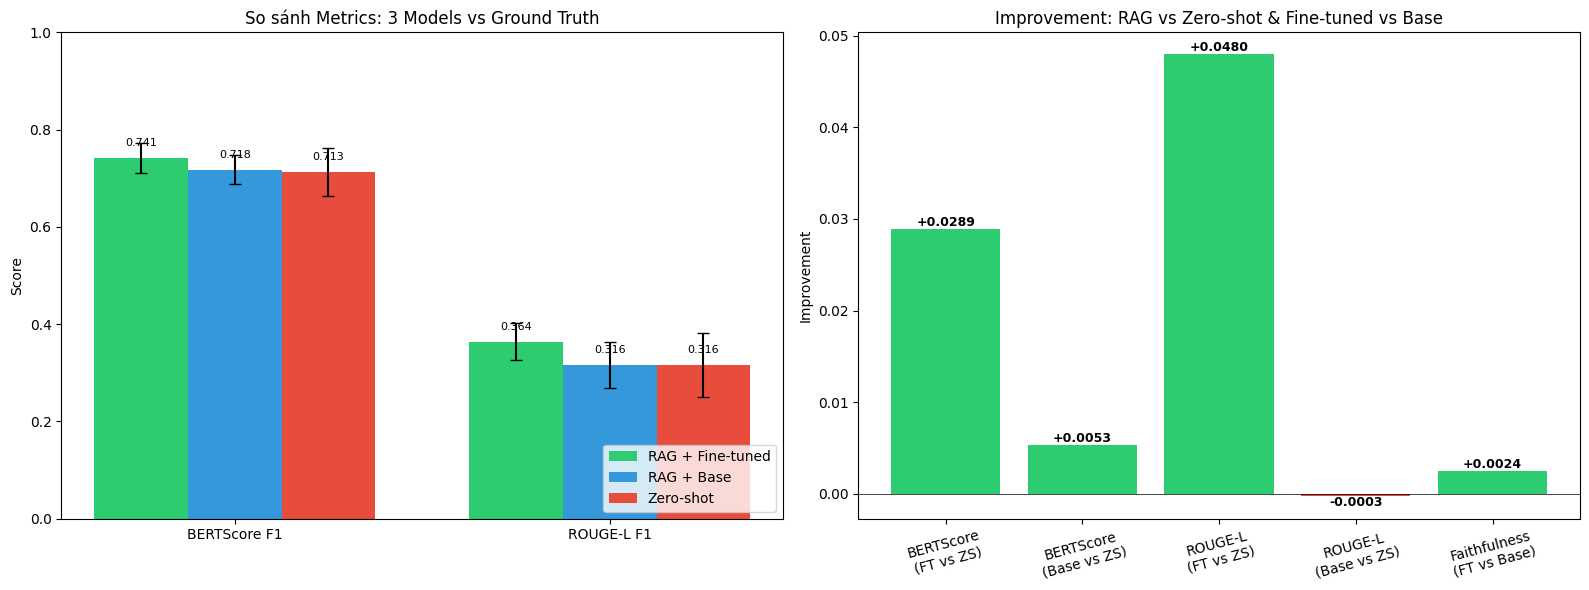


✓ Chart saved to /kaggle/working/results/model_comparison_chart_3models.png


In [35]:
import matplotlib.pyplot as plt

# Prepare data for visualization - 3 MODELS
metrics_names = ['BERTScore F1', 'ROUGE-L F1']
ft_scores = [bertscore_ft_gt['f1'], rouge_ft_gt['f1']]
base_scores = [bertscore_base_gt['f1'], rouge_base_gt['f1']]
zs_scores = [bertscore_zs_gt['f1'], rouge_zs_gt['f1']]

ft_stds = [bertscore_ft_gt['f1_std'], rouge_ft_gt['f1_std']]
base_stds = [bertscore_base_gt['f1_std'], rouge_base_gt['f1_std']]
zs_stds = [bertscore_zs_gt['f1_std'], rouge_zs_gt['f1_std']]

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Bar chart comparison - 3 MODELS
x = np.arange(len(metrics_names))
width = 0.25

bars1 = axes[0].bar(x - width, ft_scores, width, label='RAG + Fine-tuned', color='#2ecc71', yerr=ft_stds, capsize=4)
bars2 = axes[0].bar(x, base_scores, width, label='RAG + Base', color='#3498db', yerr=base_stds, capsize=4)
bars3 = axes[0].bar(x + width, zs_scores, width, label='Zero-shot', color='#e74c3c', yerr=zs_stds, capsize=4)

axes[0].set_ylabel('Score')
axes[0].set_title('So sánh Metrics: 3 Models vs Ground Truth')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names)
axes[0].legend(loc='lower right')
axes[0].set_ylim(0, 1)

# Add value labels on bars
for bar, score in zip(bars1, ft_scores):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{score:.3f}', ha='center', va='bottom', fontsize=8)
for bar, score in zip(bars2, base_scores):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{score:.3f}', ha='center', va='bottom', fontsize=8)
for bar, score in zip(bars3, zs_scores):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{score:.3f}', ha='center', va='bottom', fontsize=8)

# Subplot 2: Faithfulness comparison (only RAG models) + RAG improvement over Zero-shot
# Show improvement of RAG models over Zero-shot baseline
improvement_names = ['BERTScore\n(FT vs ZS)', 'BERTScore\n(Base vs ZS)', 'ROUGE-L\n(FT vs ZS)', 'ROUGE-L\n(Base vs ZS)', 'Faithfulness\n(FT vs Base)']
improvements = [
    bertscore_ft_gt['f1'] - bertscore_zs_gt['f1'],  # Fine-tuned vs Zero-shot
    bertscore_base_gt['f1'] - bertscore_zs_gt['f1'],  # Base vs Zero-shot
    rouge_ft_gt['f1'] - rouge_zs_gt['f1'],  # Fine-tuned vs Zero-shot
    rouge_base_gt['f1'] - rouge_zs_gt['f1'],  # Base vs Zero-shot
    faith_ft['mean'] - faith_base['mean']  # Fine-tuned vs Base (Faithfulness)
]

colors = ['#2ecc71' if d > 0 else '#e74c3c' for d in improvements]
bars4 = axes[1].bar(improvement_names, improvements, color=colors)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_ylabel('Improvement')
axes[1].set_title('Improvement: RAG vs Zero-shot & Fine-tuned vs Base')
axes[1].tick_params(axis='x', rotation=15)

# Add value labels
for bar, diff in zip(bars4, improvements):
    va = 'bottom' if diff >= 0 else 'top'
    axes[1].text(bar.get_x() + bar.get_width()/2, diff, 
                 f'{diff:+.4f}', ha='center', va=va, fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/model_comparison_chart_3models.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Chart saved to {OUTPUT_DIR}/model_comparison_chart_3models.png")

## 22. Phân tích chi tiết từng sample

In [36]:
# Create detailed comparison dataframe with ground truth - 3 MODELS
df_detailed = pd.DataFrame({
    'question': questions,
    'ground_truth': ground_truth_answers,
    'finetuned_answer': finetuned_answers,
    'base_answer': base_answers,
    'zeroshot_answer': zeroshot_answers,
})

# Add BERTScore for each sample - 3 MODELS
from bert_score import score as bert_score_fn

# Compute per-sample BERTScore
_, _, ft_f1_scores = bert_score_fn(finetuned_answers, ground_truth_answers, lang='vi', verbose=False)
_, _, base_f1_scores = bert_score_fn(base_answers, ground_truth_answers, lang='vi', verbose=False)
_, _, zs_f1_scores = bert_score_fn(zeroshot_answers, ground_truth_answers, lang='vi', verbose=False)

df_detailed['bertscore_ft'] = ft_f1_scores.numpy()
df_detailed['bertscore_base'] = base_f1_scores.numpy()
df_detailed['bertscore_zs'] = zs_f1_scores.numpy()
df_detailed['bertscore_diff_ft_base'] = df_detailed['bertscore_ft'] - df_detailed['bertscore_base']
df_detailed['bertscore_diff_ft_zs'] = df_detailed['bertscore_ft'] - df_detailed['bertscore_zs']

# Show samples where RAG + Fine-tuned is best
print("=" * 70)
print("TOP 5 SAMPLES: RAG + Fine-tuned performs BEST")
print("=" * 70)
top_ft = df_detailed.nlargest(5, 'bertscore_ft')
for i, row in top_ft.iterrows():
    print(f"\n Question: {row['question'][:100]}...")
    print(f"   Ground Truth: {row['ground_truth'][:120]}...")
    print(f"   Fine-tuned: {row['finetuned_answer'][:120]}...")
    print(f"   Base: {row['base_answer'][:120]}...")
    print(f"   Zero-shot: {row['zeroshot_answer'][:120]}...")
    print(f"   BERTScore: FT={row['bertscore_ft']:.4f}, Base={row['bertscore_base']:.4f}, ZS={row['bertscore_zs']:.4f}")

# Show samples where Fine-tuned >> Base (biggest improvement from fine-tuning)
print("\n" + "=" * 70)
print("TOP 5 SAMPLES: Fine-tuned >> Base (biggest fine-tuning gain)")
print("=" * 70)
top_ft_vs_base = df_detailed.nlargest(5, 'bertscore_diff_ft_base')
for i, row in top_ft_vs_base.iterrows():
    print(f"\n Question: {row['question'][:100]}...")
    print(f"   Ground Truth: {row['ground_truth'][:120]}...")
    print(f"   Fine-tuned: {row['finetuned_answer'][:120]}...")
    print(f"   Base: {row['base_answer'][:120]}...")
    print(f"   Improvement: FT={row['bertscore_ft']:.4f}, Base={row['bertscore_base']:.4f}, Diff={row['bertscore_diff_ft_base']:+.4f}")

# Show samples where RAG >> Zero-shot (biggest RAG improvement)
print("\n" + "=" * 70)
print("TOP 5 SAMPLES: RAG + Fine-tuned >> Zero-shot (RAG helps most)")
print("=" * 70)
top_rag_vs_zs = df_detailed.nlargest(5, 'bertscore_diff_ft_zs')
for i, row in top_rag_vs_zs.iterrows():
    print(f"\n Question: {row['question'][:100]}...")
    print(f"   Ground Truth: {row['ground_truth'][:120]}...")
    print(f"   Fine-tuned (RAG): {row['finetuned_answer'][:120]}...")
    print(f"   Zero-shot: {row['zeroshot_answer'][:120]}...")
    print(f"   RAG Improvement: FT={row['bertscore_ft']:.4f}, ZS={row['bertscore_zs']:.4f}, Diff={row['bertscore_diff_ft_zs']:+.4f}")

TOP 5 SAMPLES: RAG + Fine-tuned performs BEST

 Question: Hình tượng rồng được trang trí trên mũi thuyền trong bức ảnh này mang những ý nghĩa biểu trưng sâu s...
   Ground Truth: Biểu tượng của sức mạnh, quyền uy và thịnh vượng. Trong văn hóa và tín ngưỡng Việt Nam, rồng là một linh vật thiêng liên...
   Fine-tuned: Rồng là linh vật thiêng liêng, biểu tượng cho sức mạnh, quyền lực và sự may mắn.

Trong văn hóa Việt, rồng là biểu tượng...
   Base: Hình tượng rồng trên mũi thuyền tại bức ảnh này có nhiều ý nghĩa biểu tượng sâu sắc trong văn hóa Việt. Rồng thường được...
   Zero-shot: Rồng là một biểu tượng quan trọng trong văn hóa và tín ngưỡng của người Việt Nam. Rồng được trang trí trên mũi thuyền có...
   BERTScore: FT=0.8089, Base=0.7400, ZS=0.6387

 Question: Cây cột được trang trí bằng các hình cắt giấy và các vật phẩm sặc sỡ ở trung tâm bức ảnh có tên gọi ...
   Ground Truth: Đây là một loại cột lễ hay cây nghi lễ quan trọng trong các nghi thức tín ngưỡng của người Dao Đỏ. Cây cột

## 23. Lưu kết quả

In [37]:
# Save detailed results to CSV - 3 MODELS
output_csv = f"{OUTPUT_DIR}/model_comparison_detailed.csv"
df_detailed.to_csv(output_csv, index=False, encoding='utf-8')
print(f" Detailed results saved to {output_csv}")

# Save summary metrics to JSON - 3 MODELS
summary_metrics = {
    "fine_tuned_model": str(FINETUNED_MODEL_PATH),
    "base_model": BASE_MODEL_ID,
    "zeroshot_model": "Qwen/Qwen2-VL-2B-Instruct",
    "num_samples": len(valid_images),
    "metrics_vs_ground_truth": {
        "finetuned": {
            "bertscore_f1": bertscore_ft_gt['f1'],
            "bertscore_f1_std": bertscore_ft_gt['f1_std'],
            "rouge_l_f1": rouge_ft_gt['f1'],
            "rouge_l_f1_std": rouge_ft_gt['f1_std'],
            "faithfulness_mean": faith_ft['mean'],
            "faithfulness_std": faith_ft['std']
        },
        "base": {
            "bertscore_f1": bertscore_base_gt['f1'],
            "bertscore_f1_std": bertscore_base_gt['f1_std'],
            "rouge_l_f1": rouge_base_gt['f1'],
            "rouge_l_f1_std": rouge_base_gt['f1_std'],
            "faithfulness_mean": faith_base['mean'],
            "faithfulness_std": faith_base['std']
        },
        "zeroshot": {
            "bertscore_f1": bertscore_zs_gt['f1'],
            "bertscore_f1_std": bertscore_zs_gt['f1_std'],
            "rouge_l_f1": rouge_zs_gt['f1'],
            "rouge_l_f1_std": rouge_zs_gt['f1_std'],
            "faithfulness_mean": None,  # Zero-shot không có context
            "faithfulness_std": None
        }
    },
    "improvement_finetuned_vs_base": {
        "bertscore_f1": bertscore_ft_gt['f1'] - bertscore_base_gt['f1'],
        "rouge_l_f1": rouge_ft_gt['f1'] - rouge_base_gt['f1'],
        "faithfulness": faith_ft['mean'] - faith_base['mean']
    },
    "improvement_rag_vs_zeroshot": {
        "finetuned_vs_zeroshot": {
            "bertscore_f1": bertscore_ft_gt['f1'] - bertscore_zs_gt['f1'],
            "rouge_l_f1": rouge_ft_gt['f1'] - rouge_zs_gt['f1']
        },
        "base_vs_zeroshot": {
            "bertscore_f1": bertscore_base_gt['f1'] - bertscore_zs_gt['f1'],
            "rouge_l_f1": rouge_base_gt['f1'] - rouge_zs_gt['f1']
        }
    }
}

output_json = f"{OUTPUT_DIR}/model_comparison_metrics.json"
with open(output_json, 'w', encoding='utf-8') as f:
    json.dump(summary_metrics, f, indent=2, ensure_ascii=False)
print(f" Summary metrics saved to {output_json}")

print("\n" + "="*80)
print(" EVALUATION COMPLETE - 3 MODELS!")
print("="*80)
print(f"\nOutput files:")
print(f"   {OUTPUT_DIR}/benchmark_inference_results_finetuned.json")
print(f"   {OUTPUT_DIR}/benchmark_inference_results_base.json")
print(f"   {OUTPUT_DIR}/benchmark_inference_results_zeroshot.json")
print(f"   {OUTPUT_DIR}/model_comparison_detailed.csv")
print(f"   {OUTPUT_DIR}/model_comparison_metrics.json")
print(f"   {OUTPUT_DIR}/model_comparison_chart_3models.png")

 Detailed results saved to /kaggle/working/results/model_comparison_detailed.csv
 Summary metrics saved to /kaggle/working/results/model_comparison_metrics.json

 EVALUATION COMPLETE - 3 MODELS!

Output files:
   /kaggle/working/results/benchmark_inference_results_finetuned.json
   /kaggle/working/results/benchmark_inference_results_base.json
   /kaggle/working/results/benchmark_inference_results_zeroshot.json
   /kaggle/working/results/model_comparison_detailed.csv
   /kaggle/working/results/model_comparison_metrics.json
   /kaggle/working/results/model_comparison_chart_3models.png
